### Churn predication using various classification models on kaggle telco churn dataset

Makes use of:
- Downsampling to address class imbalance
- RandomForest used with gridsearch for hyperparameter tuning
- SHAP for global and local feature interpretability

**Key conclusions** for telco:

- By predicting churn, the company can intercede to reduce the
likelihood of the identified customer cancelling their service

- Calls to customer service is a key indicator of churn -- higher
numbers of calls to customer service for churning customers suggest
a higher risk of churn for those customers with a higher number of 
calls to customer service; to minimise churn efforts should be made
to resolve customer issue(s) in the minimum number of calls

- International plan and total day charge/minutes seem to be the
other important features; these features would suggest that the
person using the telephone may spend more as a result of a higher
proportion of daytime and international calls (both less likely
to be on a cheaper plan); this suggests that customers are economically
rational, on the presupposition that they may be able to get a
better deal elsewhere, as a heavier user of the service -- this would
be a point to clarify with someone with suitable domain knowledge

- The State that the customer resides in has negligible impact

**Model**:

- Recall is key metric as we want to minimise false negatives

- Random forest model achieves 0.93 ROC AUC and 0.91 recall on (20%) test set

- From the summary stats on the model training data we can see that churners:
    - Are c. 5x more likely to have an international plan
    - Have higher mean and median day minutes (17% and 22% respectively)
    - Have higher mean and median customer service calls (55% and
    100% respectively)
- This suggests that the model is reasonably well calibrated as
these reflect the key feature importances/SHAP values


In [52]:
import pandas as pd
import numpy as np

import shap

from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, PrecisionRecallCurve

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, make_scorer

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [3]:
default_figsize = plt.rcParams["figure.figsize"]
custom_figsize = (12, 5)

plt.rcParams["figure.figsize"] = custom_figsize

In [4]:
%ls churn-analytics-bda

churnTest.csv*         churnTrain.csv*        sample_submission.csv*


In [5]:
df = pd.read_csv('churn-analytics-bda/churnTrain.csv')
print('Shape of raw training data', df.shape)

Shape of raw training data (3333, 21)


In [6]:
print('Head of raw training data')
df.head()

Head of raw training data


,State,Account_Length,Area_Code,Phone_No,International_Plan,Voice_Mail_Plan,No_Vmail_Messages,Total_Day_minutes,Total_Day_Calls,Total_Day_charge,...,Total_Eve_Calls,Total_Eve_Charge,Total_Night_Minutes,Total_Night_Calls,Total_Night_Charge,Total_Intl_Minutes,Total_Intl_Calls,Total_Intl_Charge,No_CS_Calls,Churn
0,KS,128,415,3824657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,3717191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,3581921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,3759999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,3306626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [7]:
print('types\n\n', df.dtypes)

types

 State                   object
Account_Length           int64
Area_Code                int64
Phone_No                 int64
International_Plan      object
Voice_Mail_Plan         object
No_Vmail_Messages        int64
Total_Day_minutes      float64
Total_Day_Calls          int64
Total_Day_charge       float64
Total_Eve_Minutes      float64
Total_Eve_Calls          int64
Total_Eve_Charge       float64
Total_Night_Minutes    float64
Total_Night_Calls        int64
Total_Night_Charge     float64
Total_Intl_Minutes     float64
Total_Intl_Calls         int64
Total_Intl_Charge      float64
No_CS_Calls              int64
Churn                     bool
dtype: object


In [8]:
# Make Churn numeric
df['Churn'] = df['Churn'] * 1

In [9]:
# Map International_Plan and Voice_Mail_Plan to ints

# Check we get what we expect with the mapping
print('str to int mapping for international plan\n\n', df.International_Plan.map({' no':0, ' yes':1}).value_counts())
# Do mapping
df['International_Plan'] = df.International_Plan.map({' no':0, ' yes':1})

# Check mapping works
print('\nstr to int mapping for voice mail plan\n\n', df.Voice_Mail_Plan.map({' no':0, ' yes':1}).value_counts())
# Do mapping
df['Voice_Mail_Plan'] = df.Voice_Mail_Plan.map({' no':0, ' yes':1})

str to int mapping for international plan

 0    3010
1     323
Name: International_Plan, dtype: int64

str to int mapping for voice mail plan

 0    2411
1     922
Name: Voice_Mail_Plan, dtype: int64


In [10]:
# Add dummy variables for states and drop state and Phone_No and Area_Code
print('Dummifying State, droping phone_no and area_code')
df = pd.concat([df, pd.get_dummies(df['State'], prefix='state_')], axis=1).drop(columns=['State', 'Phone_No', 'Area_Code'])

Dummifying State, droping phone_no and area_code


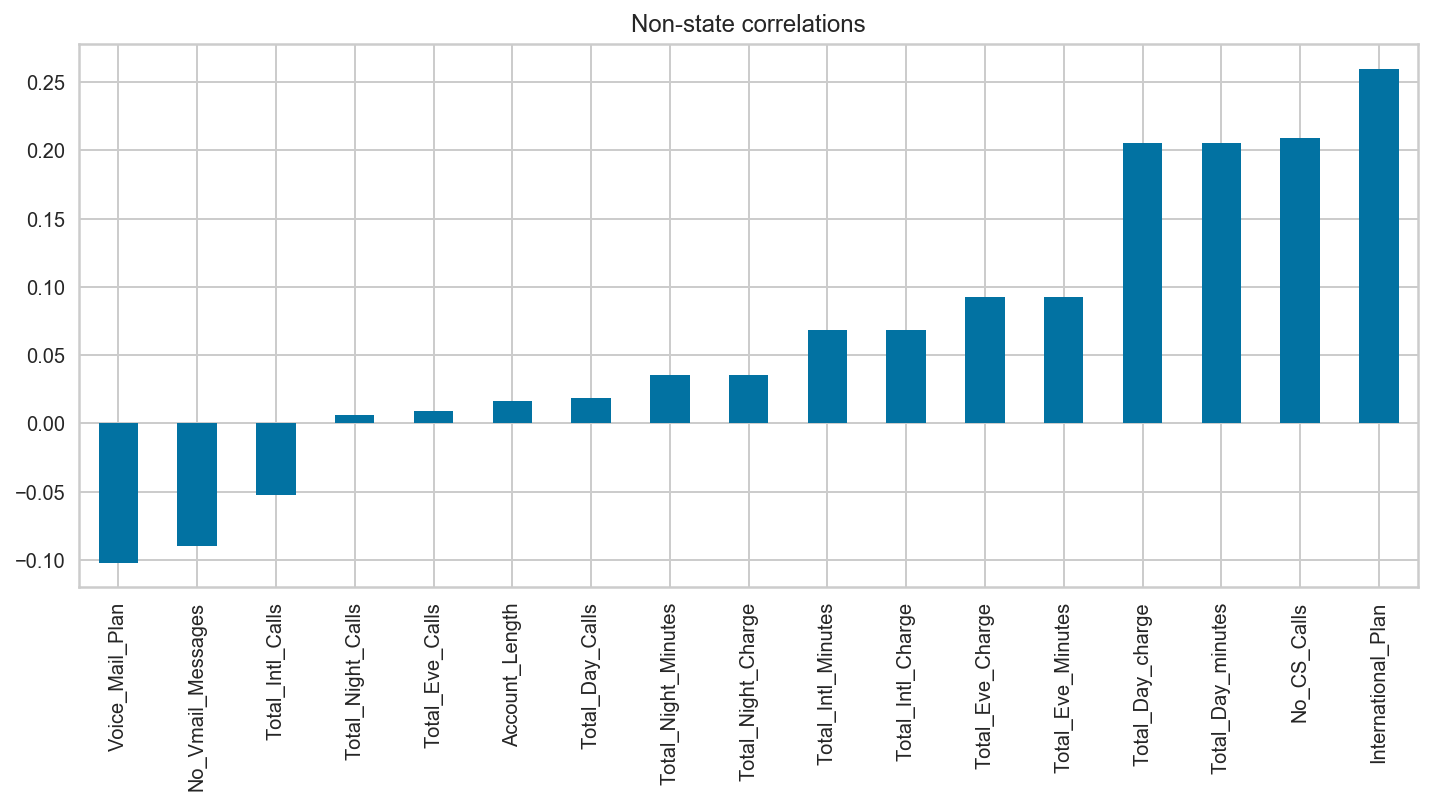

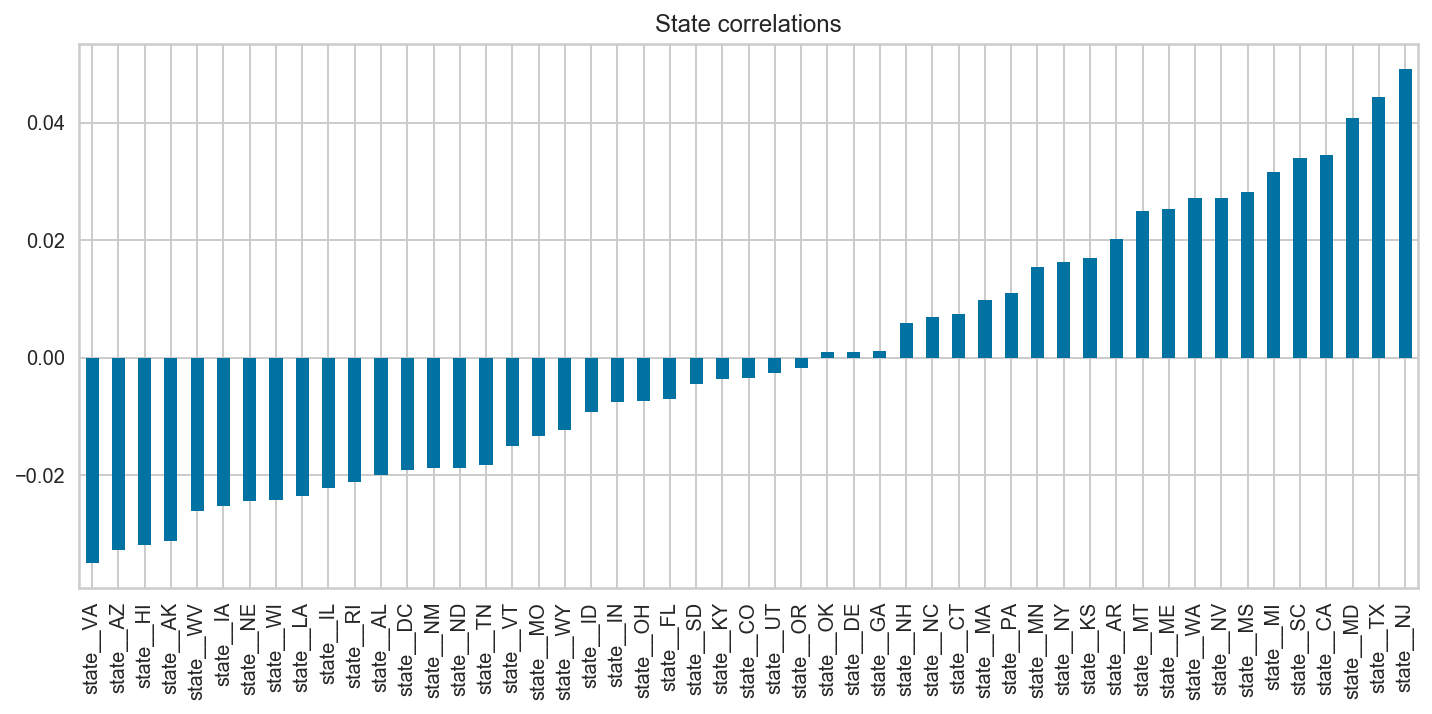

Summary stats on sum of states


count     51.000000
mean      65.352941
std       11.801396
min       34.000000
25%       59.500000
50%       65.000000
75%       72.500000
max      106.000000
dtype: float64

In [11]:
# Check correlations

# Let's see what correlates with churn
df_corr = df.corr()

# Exclude churn itself and the state dummy variables
state_idx = [idx for idx in df_corr.index if 'state' in idx]

df_corr.loc[~df_corr.index.isin(['Churn'] + state_idx), 'Churn'].sort_values().plot.bar(title='Non-state correlations'); plt.show()
df_corr.loc[df_corr.index.isin(state_idx), 'Churn'].sort_values().plot.bar(title='State correlations'); plt.show()

# We have at least 34 samples per state so potentially enough to take notice of correlations
print('Summary stats on sum of states')

# Note that we only have small numbers of states
df.T.loc[state_idx].sum(axis=1).describe()

In [12]:
# What's our baseline
print('Proportionate class frequencies are\n\n', df['Churn'].value_counts(normalize=True))

Proportionate class frequencies are

 0    0.855086
1    0.144914
Name: Churn, dtype: float64


In [13]:
print('Downsampling majority class to address class imbalance')

# Prep for class imbalance
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(df, df['Churn'])

y = df['Churn'].copy(deep=True)
X = df.copy(deep=True)

for train_index, test_index in sss.split(X, y):
    #print("Train idx:", train_index)
    #print("Test idx:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
print('m_test is', len(X_test), '\n'+'m_test as proportion of total is', round(len(X_test)/len(X), 3))

print('\nProporitonate classes before downsampling for y_train are\n\n', y_train.value_counts(normalize=True))

# Separate majority and minority classes
df_majority = X_train[y_train == 0]
df_minority = X_train[y_train == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=0) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print('\nClass counts after downsample\n\n', df_downsampled.Churn.value_counts())

X_train = df_downsampled.copy(deep=True)
y_train = X_train.pop('Churn')
y_test = X_test.pop('Churn')

print('\n')
print('X_train shape', X_train.shape, y_train.shape)
print('X_test shape', X_test.shape, y_test.shape)

Downsampling majority class to address class imbalance
m_test is 667 
m_test as proportion of total is 0.2

Proporitonate classes before downsampling for y_train are

 0    0.855214
1    0.144786
Name: Churn, dtype: float64

Class counts after downsample

 1    386
0    386
Name: Churn, dtype: int64


X_train shape (772, 68) (772,)
X_test shape (667, 68) (667,)


In [14]:
def model_evaluation(model, X_train, y_train, X_test, y_test, visualisations=True):
    
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    
    # Accuracy = TP+TN/TP+FP+FN+TN
    print('\nAccuracy\n---\n')
    print('Cross validation accuracy:', cross_val_score(model, X_train, y_train.values, cv=6).mean().round(4)) # Mean of 6 CVs
    print('Test score accuracy:', model.score(X_test, y_test).round(4))
    
    print('\nConfusion matrix\n---\n')
    df_cm = pd.DataFrame(
        data=confusion_matrix(y_test, y_hat, labels = [1, 0]),
        index=[1,0],
        columns=[1,0]
    )

    print(df_cm)

    key_data = [['TP', 'FN'], ['FP',  'TN']]
    print('\n\nKey\n\n',
    pd.DataFrame(
        data=key_data,
        index=[1, 0],
        columns=[1, 0]
    ))

    # Precision is TP/(TP+FP)
    print('\nPrecision\n---\n')
    TP = df_cm.loc[1, 1]
    sum_TP_FP = df_cm.loc[:, 1].sum()
    print('\nTP =', TP)
    print('TP+FN =', sum_TP_FP)
    print('Precision = TP/(TP+FP)\n', (TP/sum_TP_FP).round(4))
    
    # Recall is TP/(TP+FN)
    print('\nRecall\n---\n')
    TP = df_cm.loc[1, 1]
    sum_TP_FN = df_cm.loc[1].sum()
    print('\nTP =', TP)
    print('TP+FN =', sum_TP_FN)
    print('Recall = TP/(TP+FN)\n', (TP/sum_TP_FN).round(4))
    
    if not visualisations:
        return
    
    # Diagrams for conf matrix and precision/recall/f1
    fig, ax = plt.subplots(figsize=(6,6))
    cm_vis = ConfusionMatrix(model, classes=[0, 1], ax=ax)
    cm_vis.fit(X_train, y_train)
    cm_vis.score(X_test, y_test)
    cm_vis.show()
    
    fig, ax = plt.subplots(figsize=(9,6))
    class_vis = ClassificationReport(model, ax=ax)
    class_vis.fit(X_train, y_train)
    class_vis.score(X_test, y_test)
    class_vis.show()
    
    # ROC and PRC diagrams
    fig, ax = plt.subplots(figsize=(9,6))
    roc_vis = ROCAUC(model, micro=False, per_class=False, ax=ax)
    roc_vis.fit(X_train, y_train)
    roc_vis.score(X_test, y_test)
    roc_vis.show()

    fig, ax = plt.subplots(figsize=(9,6))
    prc_vis = PrecisionRecallCurve(model, ax=ax)
    prc_vis.fit(X_train, y_train)
    prc_vis.score(X_test, y_test)
    prc_vis.show()
    
    # Graph of coefs
    # Check for feature_importances_ or coef_
    if hasattr(model, 'feature_importances_'):
        coefs = model.feature_importances_.reshape(-1)
    else:
        coefs = model.coef_.reshape(-1)
    
    df_coefs = pd.DataFrame(data=coefs, index=X_test.columns, columns=['coef'])
    df_coefs.loc[[x for x in df_coefs.index if 'state' not in x]].sort_values(by='coef').plot.bar(title='Non-state coefs/importances'); plt.show()
    df_coefs.loc[[x for x in df_coefs.index if 'state' in x]].sort_values(by='coef').plot.bar(title='State coefs/importances'); plt.show()

In [22]:
model = LogisticRegression(solver='liblinear', penalty='l1', random_state=0) # class_weight='balanced' not needed as we downsampled
model_evaluation(model, X_train, y_train, X_test, y_test, visualisations=False)


Accuracy
---

Cross validation accuracy: 0.7591
Test score accuracy: 0.7751

Confusion matrix
---

     1    0
1   74   23
0  127  443


Key

     1   0
1  TP  FN
0  FP  TN

Precision
---


TP = 74
TP+FN = 201
Precision = TP/(TP+FP)
 0.3682

Recall
---


TP = 74
TP+FN = 97
Recall = TP/(TP+FN)
 0.7629


In [23]:
# AdaBoost with random forest
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, random_state=0), n_estimators=100, random_state=0)
model_evaluation(model, X_train, y_train, X_test, y_test, visualisations=False)


Accuracy
---

Cross validation accuracy: 0.7799
Test score accuracy: 0.7751

Confusion matrix
---

     1    0
1   73   24
0  126  444


Key

     1   0
1  TP  FN
0  FP  TN

Precision
---


TP = 73
TP+FN = 199
Precision = TP/(TP+FP)
 0.3668

Recall
---


TP = 73
TP+FN = 97
Recall = TP/(TP+FN)
 0.7526


In [32]:
# AdaBoost with ensemble of RandomForests
model = AdaBoostClassifier(RandomForestClassifier(random_state=0, n_estimators=100), n_estimators=100, random_state=0)
model_evaluation(model, X_train, y_train, X_test, y_test, visualisations=False)


Accuracy
---

Cross validation accuracy: 0.8498
Test score accuracy: 0.8861

Confusion matrix
---

    1    0
1  88    9
0  67  503


Key

     1   0
1  TP  FN
0  FP  TN

Precision
---


TP = 88
TP+FN = 155
Precision = TP/(TP+FP)
 0.5677

Recall
---


TP = 88
TP+FN = 97
Recall = TP/(TP+FN)
 0.9072


In [53]:
# GradiestBoosted trees
model = GradientBoostingClassifier(n_estimators=100, random_state=0)
model_evaluation(model, X_train, y_train, X_test, y_test, visualisations=False)


Accuracy
---

Cross validation accuracy: 0.8382
Test score accuracy: 0.8801

Confusion matrix
---

    1    0
1  86   11
0  69  501


Key

     1   0
1  TP  FN
0  FP  TN

Precision
---


TP = 86
TP+FN = 155
Precision = TP/(TP+FP)
 0.5548

Recall
---


TP = 86
TP+FN = 97
Recall = TP/(TP+FN)
 0.8866


In [33]:
# Random forest
model = RandomForestClassifier(n_estimators=100, random_state=0)
model_evaluation(model, X_train, y_train, X_test, y_test, visualisations=False)


Accuracy
---

Cross validation accuracy: 0.842
Test score accuracy: 0.8906

Confusion matrix
---

    1    0
1  88    9
0  64  506


Key

     1   0
1  TP  FN
0  FP  TN

Precision
---


TP = 88
TP+FN = 152
Precision = TP/(TP+FP)
 0.5789

Recall
---


TP = 88
TP+FN = 97
Recall = TP/(TP+FN)
 0.9072


In [34]:
print('Default params for random forest:\n')

from pprint import pprint
pprint(model.get_params())

Default params for random forest:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [35]:
# Let's GS over:

# n_estimators = # trees
# max_features = # max features considered at each split
# max_depth = # levels in the tree
# min_samples_split = # min levels in node before split
# min_samples_leaf = # min data points in given leaf
# bootstrap = # sampling with/without replacement

n_estimators = list(np.linspace(100, 1000, 3).astype(int))
#n_estimators = [100]

max_features = ['auto', 'sqrt']

max_depth = list(np.linspace(1, 5, 4).astype(int))
max_depth.append(None) # Allow unlimited too

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_state = [0]

# Create the grid
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                      'random_state': random_state}
pprint(grid)

{'bootstrap': [True, False],
 'max_depth': [1, 2, 3, 5, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 550, 1000],
 'random_state': [0]}


In [36]:
# Use the random grid to search for best hyperparameters
recall_scorer = make_scorer(recall_score)

# Grid search
cv = GridSearchCV(RandomForestClassifier(), 
                               param_grid=grid,
                               scoring=recall_scorer,
                               cv=3, 
                               verbose=2, 
                               n_jobs=-1, iid=False)

# Fit the random search model
cv.fit(X_train, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  7.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid=

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Accuracy
---

Cross validation accuracy: 0.8523
Test score accuracy: 0.8771

Confusion matrix
---

    1    0
1  88    9
0  73  497


Key

     1   0
1  TP  FN
0  FP  TN

Precision
---


TP = 88
TP+FN = 161
Precision = TP/(TP+FP)
 0.5466

Recall
---


TP = 88
TP+FN = 97
Recall = TP/(TP+FN)
 0.9072


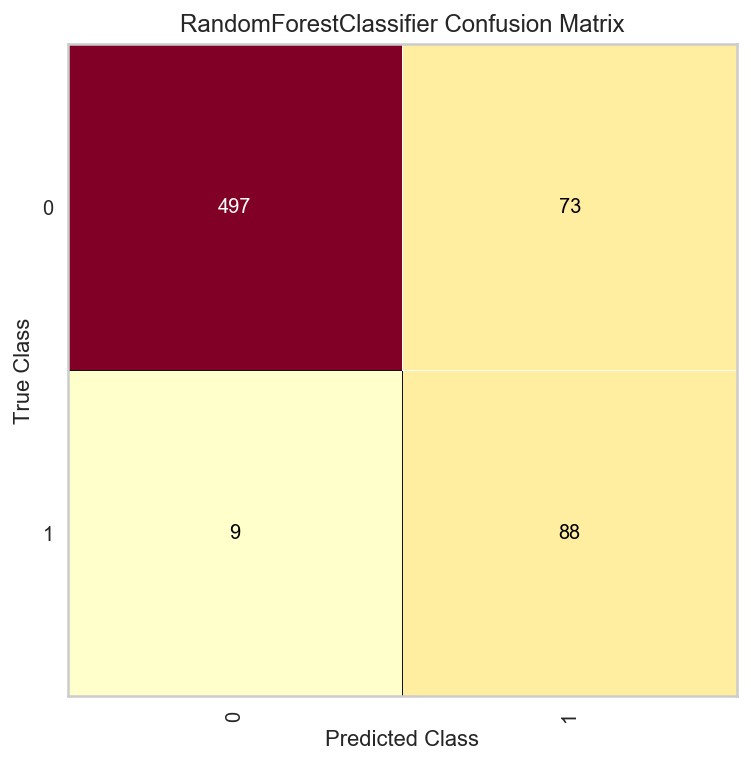

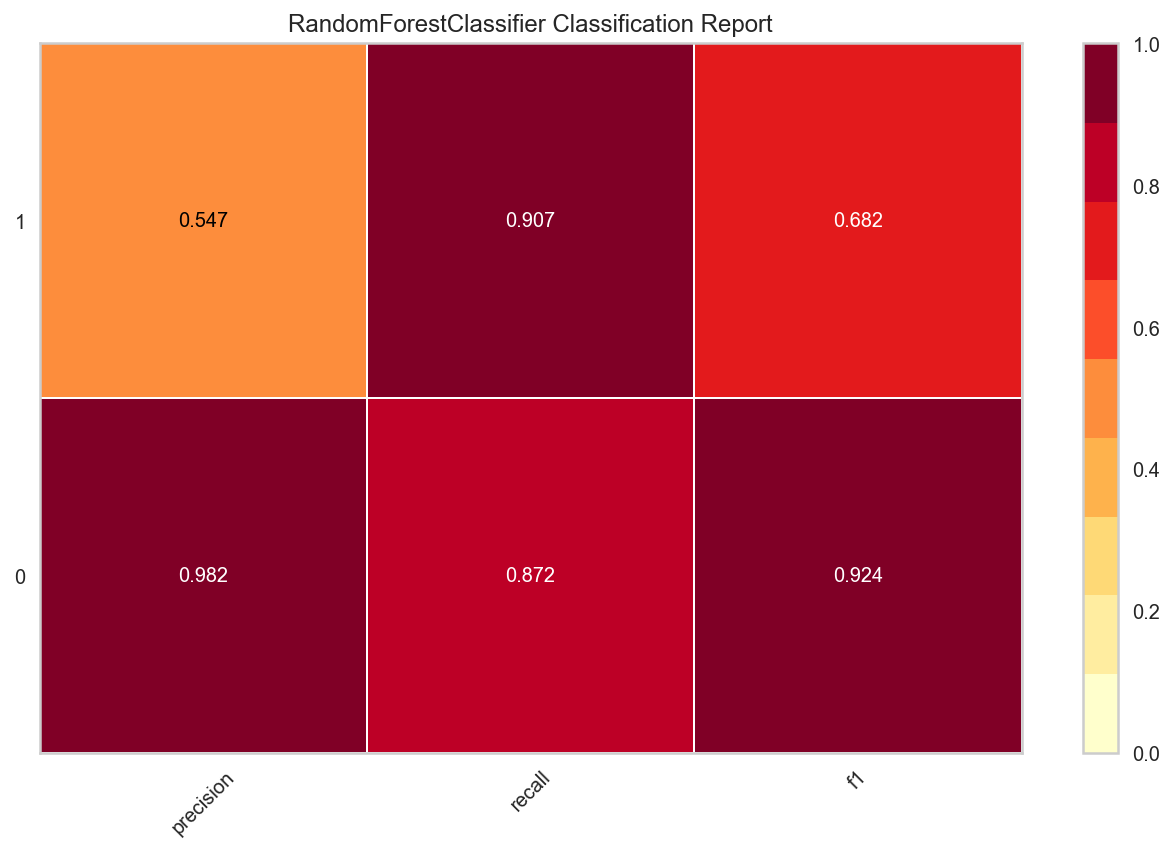

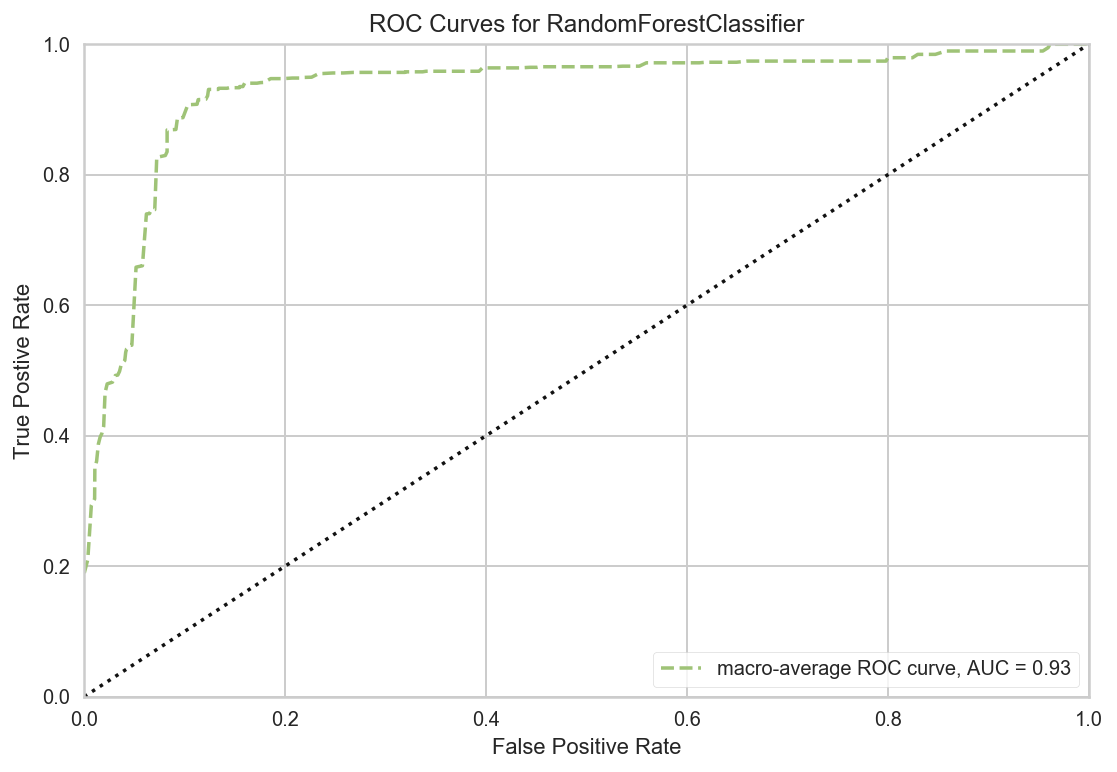

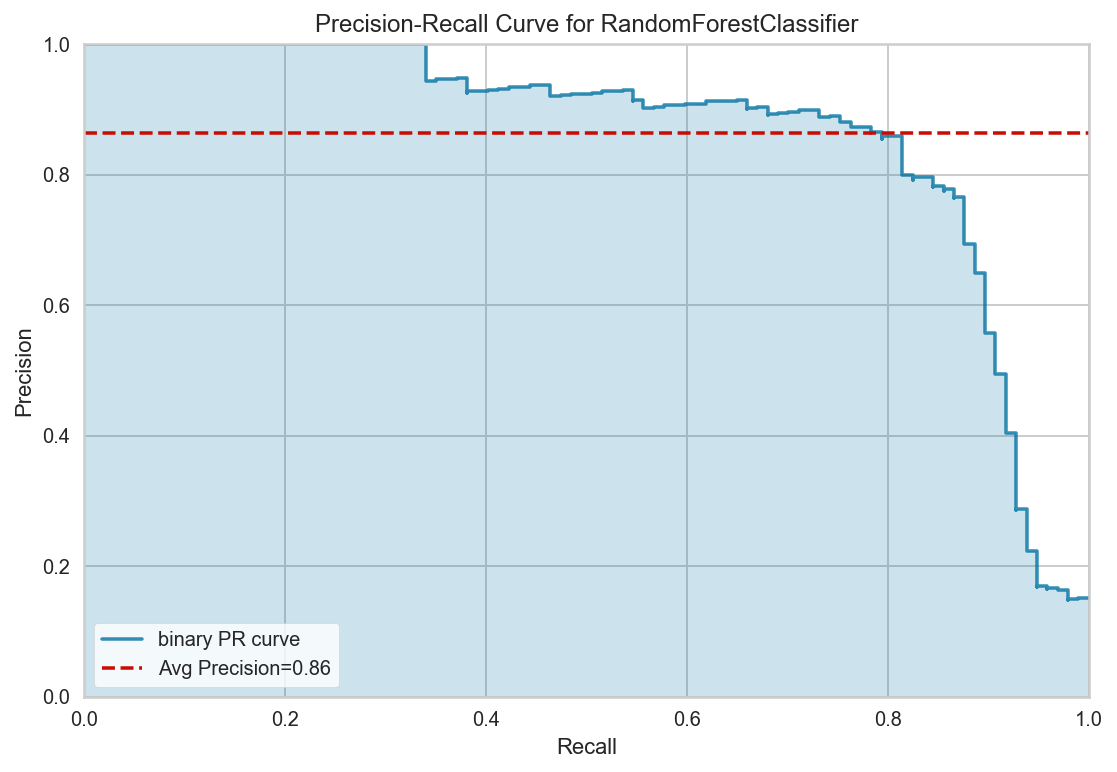

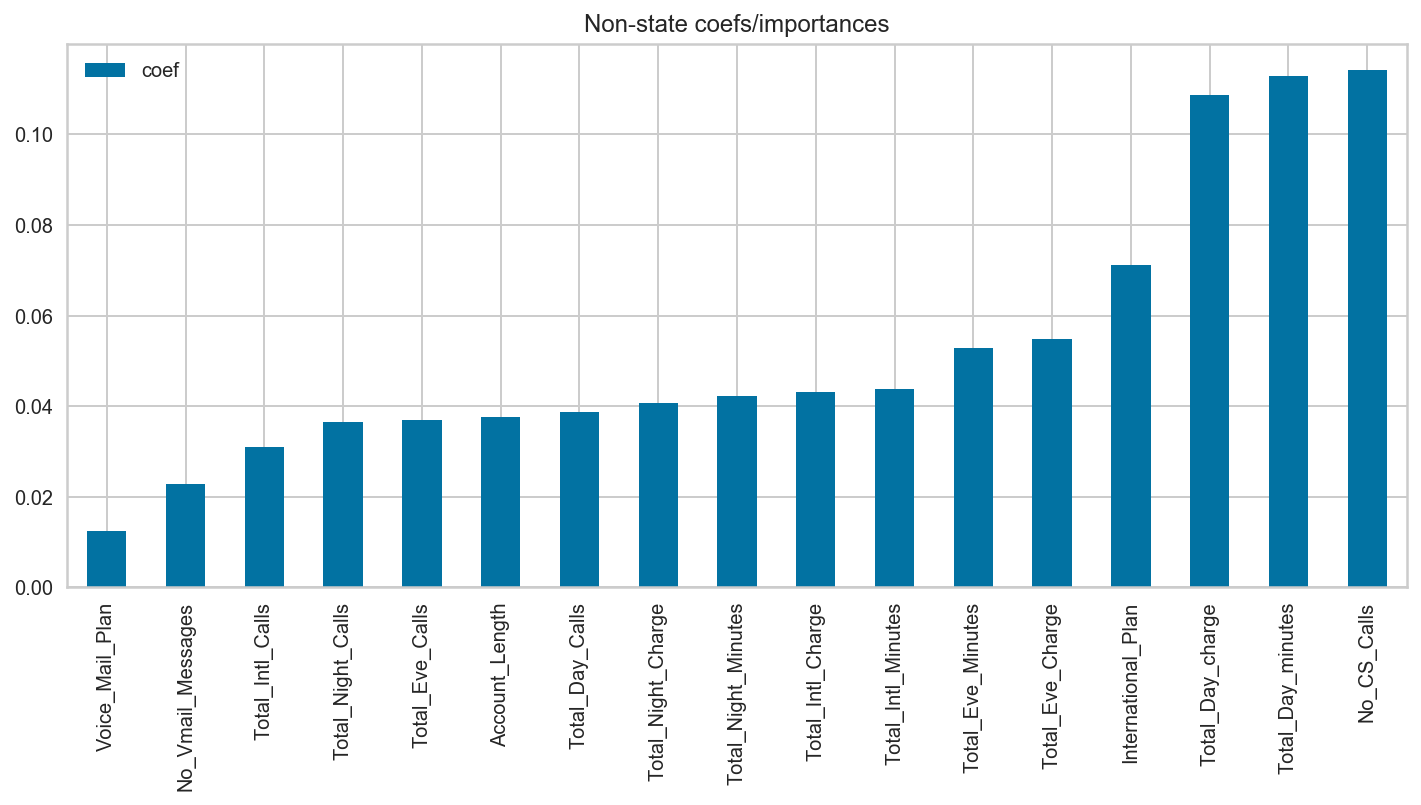

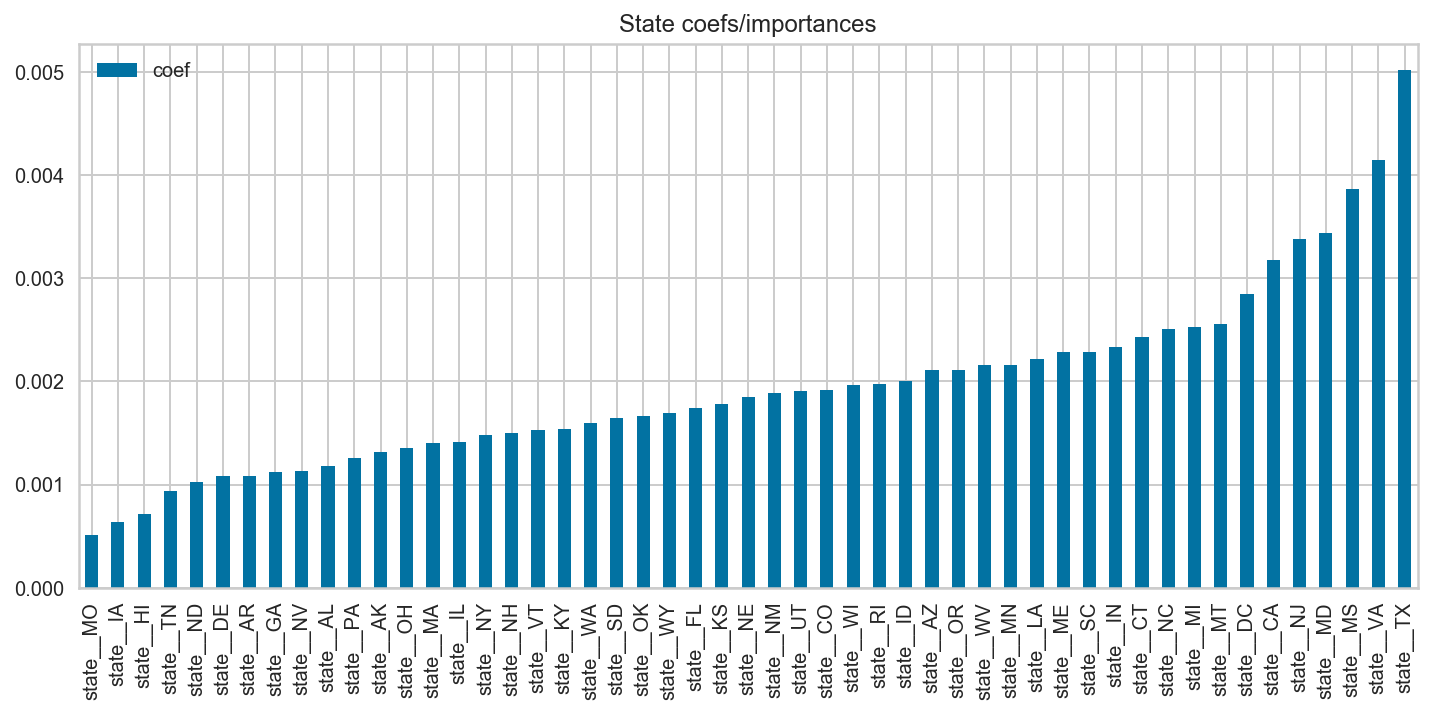

In [37]:
print(cv.best_estimator_)
model_evaluation(cv.best_estimator_, X_train, y_train, X_test, y_test, visualisations=True)

In [38]:
# If we compare the models we can see that the gridsearch has yielded no improvement over the default model
print('Default model')
print(model)
print('Recall:', recall_score(y_test, model.predict(X_test)))
print('\nBest from gridsearch')
print(cv.best_estimator_)
print('Recall:', recall_score(y_test, cv.best_estimator_.predict(X_test)))

Default model
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Recall: 0.9072164948453608

Best from gridsearch
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
  

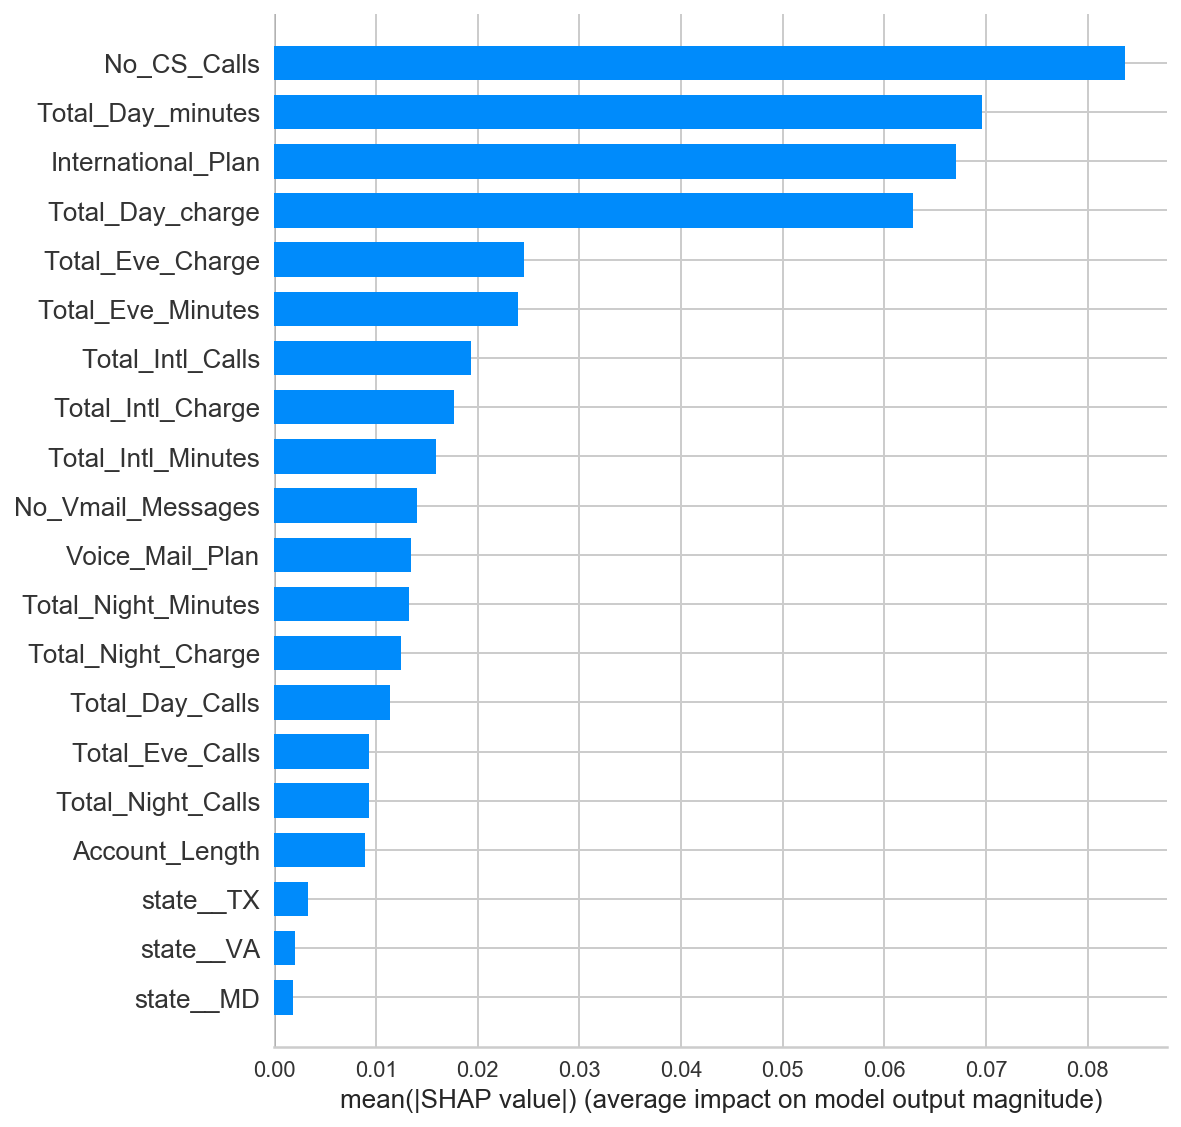

In [40]:
# Let's dig into the model a bit more with SHAP
explainer = shap.TreeExplainer(cv.best_estimator_)
shap_values_test = explainer.shap_values(X_test)
shap_values_train = explainer.shap_values(X_train)

# General explainability -- influence of features
shap.initjs()
shap.summary_plot(shap_values_train[1], X_train, plot_type="bar")

In [41]:
# If we find a misclassification
y_hat = cv.best_estimator_.predict(X_test)

# Below is the head sample of the misclassified
X_test.loc[y_test != y_hat].head()

,Account_Length,International_Plan,Voice_Mail_Plan,No_Vmail_Messages,Total_Day_minutes,Total_Day_Calls,Total_Day_charge,Total_Eve_Minutes,Total_Eve_Calls,Total_Eve_Charge,...,state__SD,state__TN,state__TX,state__UT,state__VA,state__VT,state__WA,state__WI,state__WV,state__WY
2337,139,0,0,0,181.6,119,30.87,335.7,118,28.53,...,0,0,0,0,0,0,0,0,0,0
3081,204,0,0,0,174.3,85,29.63,254.1,95,21.60,...,0,0,0,0,0,0,0,0,0,0
1652,176,0,1,23,283.2,130,48.14,162.6,74,13.82,...,0,1,0,0,0,0,0,0,0,0
495,161,1,0,0,156.1,114,26.54,180.3,63,15.33,...,0,0,0,0,0,0,0,0,0,0
1641,54,1,0,0,214.1,77,36.40,240.5,94,20.44,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# Isolate false negatives so we can inspect
cm_ = []
for i_act, i_hat in zip(y_test, y_hat):
    if i_hat == 1:
        if i_act == i_hat: cm_.append('TP')
        else: cm_.append('FP')
    else:
        # i_hat == 0
        if i_act == i_hat: cm_.append('TN')
        else: cm_.append('FN')

df_yhats = pd.DataFrame(y_hat, columns=['y_hat'])
df_yhats['type'] = cm_

# False negatives in the test set
X_test.reset_index(drop=True).loc[(df_yhats.type == 'FN')]

,Account_Length,International_Plan,Voice_Mail_Plan,No_Vmail_Messages,Total_Day_minutes,Total_Day_Calls,Total_Day_charge,Total_Eve_Minutes,Total_Eve_Calls,Total_Eve_Charge,...,state__SD,state__TN,state__TX,state__UT,state__VA,state__VT,state__WA,state__WI,state__WV,state__WY
60,60,0,0,0,179.3,147,30.48,208.9,89,17.76,...,0,0,0,0,0,0,0,0,0,0
66,133,0,0,0,117.8,100,20.03,199.2,105,16.93,...,0,0,0,0,0,0,0,0,0,0
73,113,0,0,0,128.7,100,21.88,227.1,67,19.30,...,0,0,0,0,0,0,0,0,0,0
174,168,0,0,0,163.4,134,27.78,240.1,87,20.41,...,0,0,0,0,0,0,0,0,0,0
301,73,0,0,0,217.8,91,37.03,220.6,97,18.75,...,0,0,0,0,0,1,0,0,0,0
449,91,0,0,0,153.0,123,26.01,141.1,127,11.99,...,1,0,0,0,0,0,0,0,0,0
457,98,0,0,0,165.0,129,28.05,202.6,113,17.22,...,0,0,0,0,0,0,0,0,0,0
510,101,0,1,36,123.7,125,21.03,172.6,106,14.67,...,0,0,0,0,0,0,0,0,0,0
532,92,0,0,0,154.0,122,26.18,329.8,88,28.03,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# All the false negatives in the test set have no international plan and most have 0/1/2 CS calls
key_cols = ['No_CS_Calls', 'International_Plan', 'Total_Day_minutes']
X_test.reset_index(drop=True).loc[(df_yhats.type == 'FN'), key_cols]

,No_CS_Calls,International_Plan,Total_Day_minutes
60,1,0,179.3
66,0,0,117.8
73,2,0,128.7
174,2,0,163.4
301,1,0,217.8
449,1,0,153.0
457,1,0,165.0
510,1,0,123.7
532,3,0,154.0


In [44]:
# Local explainability -- ability to look at specific false negatives in the test set
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_test[1][60, :], X_test.iloc[60, :])

In [45]:
### Further sense checking of the model by looking at the training data

# The model does very well on the training data/is potentially over-fit

# Isolate false negatives so we can inspect
y_train_hat = cv.best_estimator_.predict(X_train)

cm_ = []
for i_act, i_hat in zip(y_train, y_train_hat):
    if i_hat == 1:
        if i_act == i_hat: cm_.append('TP')
        else: cm_.append('FP')
    else:
        # i_hat == 0
        if i_act == i_hat: cm_.append('TN')
        else: cm_.append('FN')

df_train_yhats = pd.DataFrame(y_train_hat, columns=['y_hat'])
df_train_yhats['type'] = cm_

print('Results on X_train\n\n',
df_train_yhats.type.value_counts())

print('\nConfusion matrix\n---\n')
df_cm = pd.DataFrame(
    data=confusion_matrix(y_train, y_train_hat, labels = [1, 0]),
    index=[1,0],
    columns=[1,0]
)

print(df_cm)

key_data = [['TP', 'FN'], ['FP',  'TN']]
print('\n\nKey\n\n',
pd.DataFrame(
    data=key_data,
    index=[1, 0],
    columns=[1, 0]
))

# Create combined dataframe with X and y and classification result together
df_labeled_train = pd.concat([y_train.reset_index(drop=True), df_train_yhats, X_train.reset_index(drop=True)], axis=1)

Results on X_train

 TP    386
TN    386
Name: type, dtype: int64

Confusion matrix
---

     1    0
1  386    0
0    0  386


Key

     1   0
1  TP  FN
0  FP  TN


Customer Service calls non-churners and churners


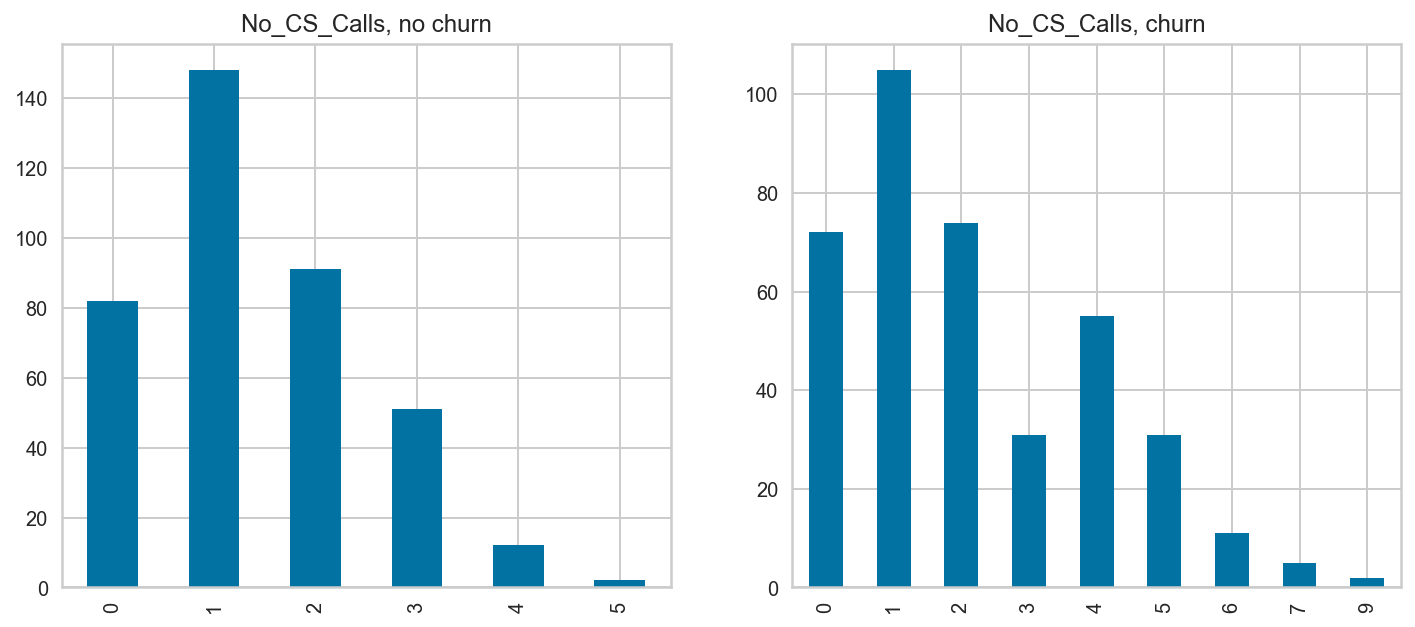

In [46]:
# Let's plot the number of CS calls for both churners and non-churners in the training set

print('Customer Service calls non-churners and churners')

col_sel = 'No_CS_Calls'

fig, ax = plt.subplots(ncols=2)

df_labeled_train.loc[df_labeled_train.Churn == 0, col_sel].value_counts().sort_index().plot.bar(ax=ax[0], title=col_sel+', no churn')
df_labeled_train.loc[df_labeled_train.Churn == 1, col_sel].value_counts().sort_index().plot.bar(ax=ax[1], title=col_sel+', churn')

plt.show()

International_Plan non-churners and churners


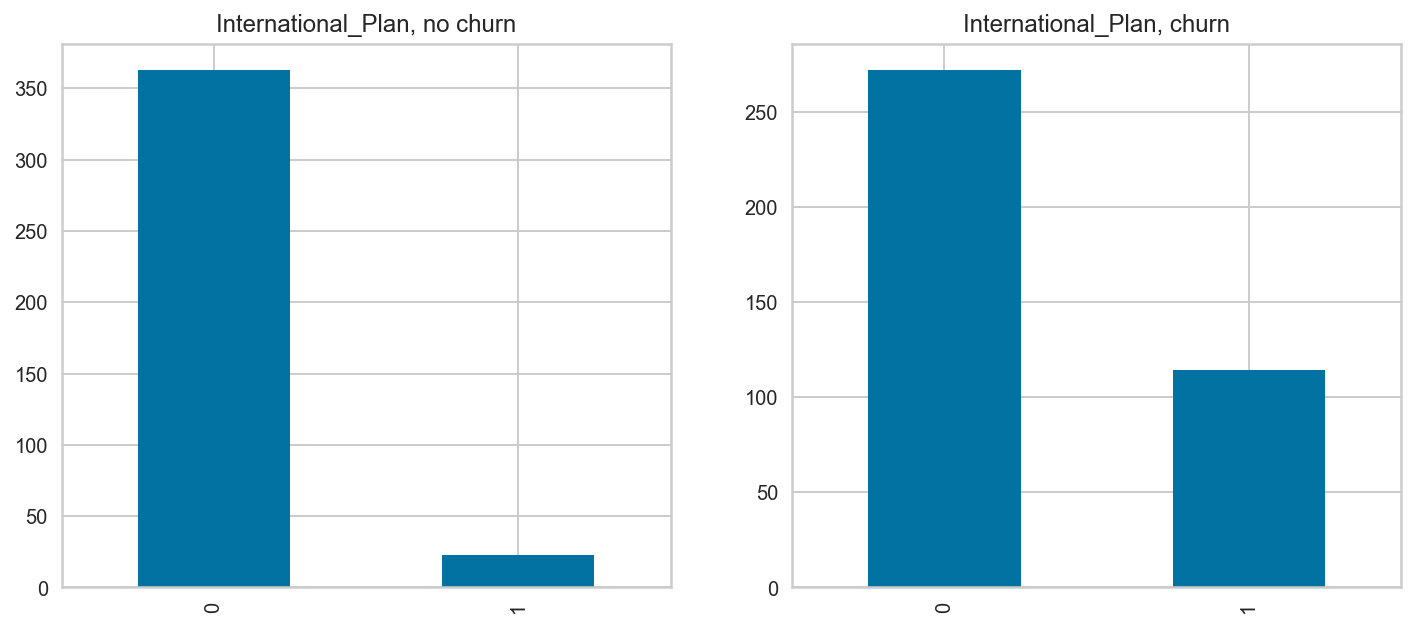

In [47]:
# Let's plot the International plan for both churners and non-churners in the training set

print('International_Plan non-churners and churners')

col_sel = 'International_Plan'

fig, ax = plt.subplots(ncols=2)

df_labeled_train.loc[df_labeled_train.Churn == 0, col_sel].value_counts().sort_index().plot.bar(ax=ax[0], title=col_sel+', no churn')
df_labeled_train.loc[df_labeled_train.Churn == 1, col_sel].value_counts().sort_index().plot.bar(ax=ax[1], title=col_sel+', churn')

plt.show()

In [48]:
# Double check that these correlate so we don't need to look at both
print('Correlation between Total_Day_charge and Total_Day_minutes:',
df_labeled_train.corr().loc['Total_Day_charge', 'Total_Day_minutes'].round(3))

Correlation between Total_Day_charge and Total_Day_minutes: 1.0


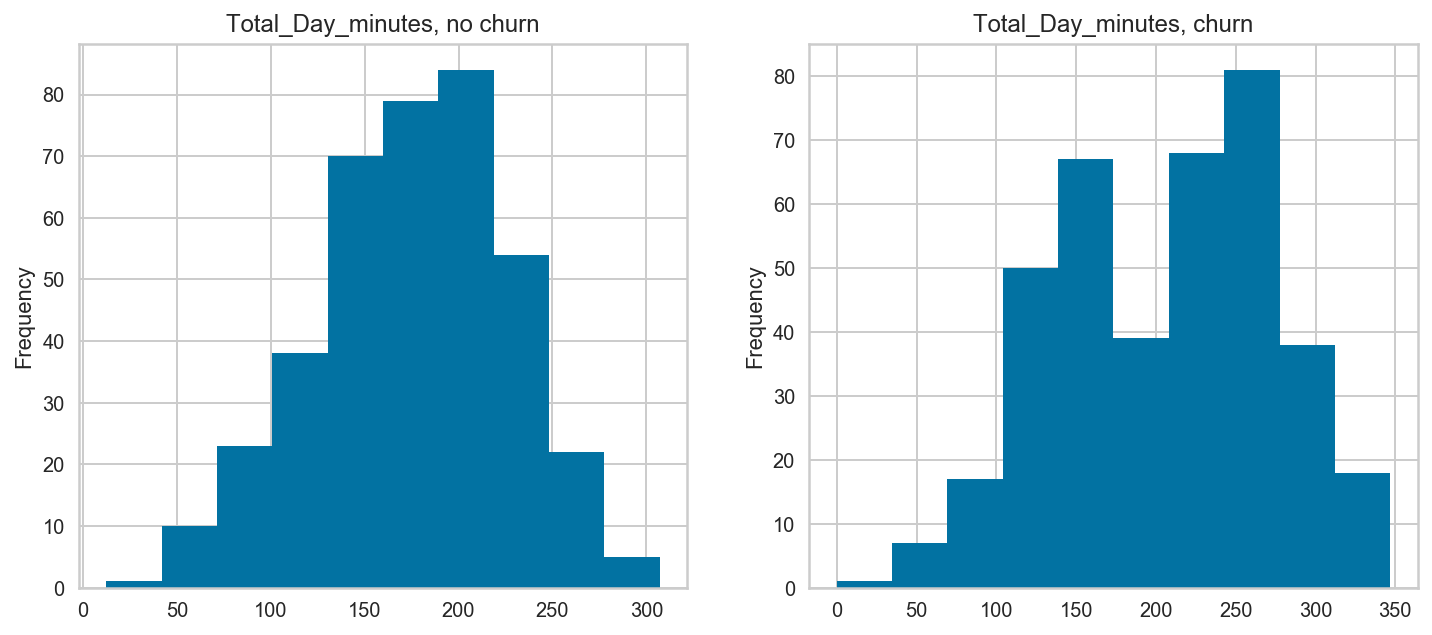

In [49]:
col_sel = 'Total_Day_minutes'

fig, ax = plt.subplots(ncols=2)

df_labeled_train.loc[df_labeled_train.Churn == 0, col_sel].plot.hist(ax=ax[0], title=col_sel+', no churn')
df_labeled_train.loc[df_labeled_train.Churn == 1, col_sel].plot.hist(ax=ax[1], title=col_sel+', churn')

plt.show()

In [50]:
key_cols = ['No_CS_Calls', 'International_Plan', 'Total_Day_minutes']

print('Summary stats for no churn\n---\n')
print(df_labeled_train.loc[df_labeled_train.Churn == 0].describe().loc[:, key_cols].round(3))

print('\n\nSummary stats for churn\n---\n')
print(df_labeled_train.loc[df_labeled_train.Churn == 1].describe().loc[:, key_cols].round(3))

print('\n\nSummary stats for whole\n---\n')
print(df_labeled_train.describe().loc[:, key_cols].round(3))

Summary stats for no churn
---

       No_CS_Calls  International_Plan  Total_Day_minutes
count      386.000             386.000            386.000
mean         1.402               0.060            175.869
std          1.087               0.237             51.296
min          0.000               0.000             12.500
25%          1.000               0.000            142.700
50%          1.000               0.000            177.300
75%          2.000               0.000            213.075
max          5.000               1.000            307.100


Summary stats for churn
---

       No_CS_Calls  International_Plan  Total_Day_minutes
count      386.000             386.000            386.000
mean         2.176               0.295            206.386
std          1.845               0.457             68.211
min          0.000               0.000              0.000
25%          1.000               0.000            154.100
50%          2.000               0.000            217.400
75%      

In [51]:
### Appendix: unused code

### Randomised CV search rather than gridsearch; gridsearch used in the end
### START

# # Use the random grid to search for best hyperparameters
# precision_scorer = make_scorer(precision_score)

# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# cv = RandomizedSearchCV(RandomForestClassifier(), 
#                                param_distributions=random_grid,
#                                scoring=precision_scorer,
#                                n_iter=100, 
#                                cv=3, 
#                                verbose=2, 
#                                random_state=0,
#                                n_jobs=-1)

# # Fit the random search model
# cv.fit(X_train, y_train)

# print(cv.best_estimator_)
# model_evaluation(cv.best_estimator_, X_train, y_train, X_test, y_test, visualisations=False)
### END

### The below is useful for tidying up the external test set (churnTest.csv), where quite a few of the features are missing

### START

# df.International_Plan.map(lambda x: type(x)).value_counts()

# df.Voice_Mail_Plan.map(lambda x: type(x)).value_counts()

# # These are the rows with NaNs in the International or Voice_Mail_Plan

# mask = df.Voice_Mail_Plan.apply(lambda x: type(x) == float) \
#     | df.International_Plan.apply(lambda x: type(x) == float)
    
# df.loc[mask]

# # Let's check the correlation between no voicemail plan and 0 No_Vmail_Messages

# pd.concat(
#     [df.loc[~mask, 'Voice_Mail_Plan'].map(lambda x: 'yes' in x),
#      df.loc[~mask, 'No_Vmail_Messages'] == 0],
#     axis=1
# ).corr()

# # We can impute that the Voice_Mail_Plan is 'no' for those which are NaN 
# # and where No_Vmail_Messages == 0

# df.loc[
#     (df.Voice_Mail_Plan.map(lambda x: type(x) == float)\
#     & (df.No_Vmail_Messages == 0)),
#     'Voice_Mail_Plan'
# ] = ' no'

# # Drop those where International Plan is NaN
# mask = df.International_Plan.isna()
# df = df.loc[~mask]

### END

### START
# Note below only needed to clean the test data
# Used just before dummification of state variables

# # Eyeball rows with nans in them
# mask_na_rows = df.isna().sum(axis=1) > 0
# df.loc[mask_na_rows, :].head(10)
# # --
# # Eyeball with median values
# df.fillna(value=df.median()).loc[mask_na_rows, :].head(10)
# # --
# # Looks ok so jam in
# df = df.fillna(value=df.median())

### END